# Convolutional neural network
You tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by (re)training a ConvNet from the pixels?

In [1]:
import importlib; import cours_proj4_funcs; 
importlib.reload(cours_proj4_funcs)
from cours_proj4_funcs import f_read_npzF, f_addIdxFeat, f_fileApp

In [2]:
import numpy as np
import os

X_tr_ini, y_tr_ini, X_data_tr, fnames_tr, y_cat_tr = f_read_npzF(os.path.join('data', 'data_train.npz'))
#X_tr_ini1 = f_addIdxFeat(X_tr_ini)

X_va_ini, y_va_ini, X_data_va, fnames_va, y_cat_va = f_read_npzF(os.path.join('data', 'data_valid.npz'))
#X_va_ini1 = f_addIdxFeat(X_va_ini)

X_te_ini, y_te_ini, X_data_te, fnames_te, y_cat_te = f_read_npzF(os.path.join('data', 'data_test.npz'))
#X_te_ini1 = f_addIdxFeat(X_te_ini)

#### - What accuracy can you achieve?

In [3]:
# Batch generator
def f_get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [4]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)
    
    ##******** Convolutional layer (64 filters, 5x5, stride: 2)
    conv1 = tf.layers.conv2d(X    #Input data
                            ,64   #filters
                            ,(5, 5)  #Kernel size
                            ,(2, 2)  #Stride
                            ,'SAME'  #"same" padding
                            ,activation = tf.nn.relu  # ReLU
                            ,kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0)
                            ,name='conv1' )  #Add name
    
    print('Convolutional layer:', conv1.shape)
    
    ## Maxpool layer (2x2, stride: 2, "same" padding)
    pool1 = tf.layers.max_pooling2d( conv1   #conv output as input
                                    ,(2, 2)  # pool size
                                    ,(2, 2)  #stride
                                    ,'SAME' )  #same padding
    
    print('Maxpool:', pool1.shape)
    
    
    ##******** Convolutional layer (64 filters, 4x4, stride: 2)
    conv2 = tf.layers.conv2d(pool1    #Input data
                            ,64   #filters
                            ,(4, 4)  #Kernel size
                            ,(2, 2)  #Stride
                            ,'SAME'  #"same" padding
                            ,activation = tf.nn.relu  # ReLU
                            ,kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0)
                            ,name='conv2' )  #Add name
    
    print('Convolutional layer:', conv2.shape)
    
    ## Maxpool layer (2x2, stride: 1, "same" padding)
    pool2 = tf.layers.max_pooling2d( conv2   #conv output as input
                                    ,(2, 2)  # pool size
                                    ,(1, 1)  #stride
                                    ,'SAME' )  #same padding
    
    print('Maxpool:', pool2.shape)
    
    ##******** Convolutional layer (64 filters, 5x5, stride: 2)
    conv3 = tf.layers.conv2d(pool2    #Input data
                            ,64   #filters
                            ,(5, 5)  #Kernel size
                            ,(2, 2)  #Stride
                            ,'SAME'  #"same" padding
                            ,activation = tf.nn.relu  # ReLU
                            ,kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0)
                            ,name='conv3' )  #Add name
    
    print('Convolutional layer:', conv3.shape)
    
    ## Maxpool layer (2x2, stride: 2, "same" padding)
    pool3 = tf.layers.max_pooling2d( conv3   #conv output as input
                                    ,(2, 2)  # pool size
                                    ,(2, 2)  #stride
                                    ,'SAME' )  #same padding
    
    print('Maxpool:', pool3.shape)
    
    ##******** Convolutional layer (64 filters, 3x3, stride: 1)
    conv4 = tf.layers.conv2d(pool3  #Max pooling output as input
                            ,64  # filters
                            ,(3, 3)  #kernel size
                            ,(1, 1)  #Stride
                            ,'SAME' # "same" padding
                            ,activation = tf.nn.relu # ReLU
                            ,kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0)
                            ,name = 'conv4' ) #Add name
    
    print('Convolutional layer:', conv4.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool4 = tf.layers.max_pooling2d( conv4  # convolution output
                                    ,(2, 2)  # pool size
                                    ,(2, 2)  #stride
                                    ,'SAME')  # padding
    print('Maxpool:', pool4.shape)
    
    
    ##************* Flatten output ***************************
    flat_output = tf.contrib.layers.flatten(pool4)
    print('Flatten:', flat_output.shape)
    
    #***** Dropout - Without dropout in order to get 1024 input units
    training = tf.placeholder(dtype=tf.bool)
    
    #flat_output = tf.layers.dropout(flat_output, seed=0, training=training, rate=0.5)
    #print('Dropout:', flat_output.shape)
    
    
    ##************* Fully connected layer **********************
    fc1 = tf.layers.dense(flat_output
                         ,256  # 256 hidden units 
                         ,activation = tf.nn.relu  # ReLU
                         ,kernel_initializer = tf.variance_scaling_initializer(scale=2, seed=0)
                         ,bias_initializer = tf.zeros_initializer() 
                         )
    
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(fc1
                            ,6 # One output unit per category
                            ,activation = None # No activation function
                            ,kernel_initializer = tf.variance_scaling_initializer(scale=1, seed=0)
                            ,bias_initializer = tf.zeros_initializer() )
    
    print('Output layer:', logits.shape)
    
    ##************* **********************************
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean( tf.nn.sparse_softmax_cross_entropy_with_logits( labels=y, logits=logits) )
    
    # Adam optimizer
    lr = tf.placeholder(dtype = tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate = lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    
    is_correct = tf.equal(y, predictions)
    
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input: (?, 224, 224, 3)
Convolutional layer: (?, 112, 112, 64)
Maxpool: (?, 56, 56, 64)
Convolutional layer: (?, 28, 28, 64)
Maxpool: (?, 28, 28, 64)
Convolutional layer: (?, 14, 14, 64)
Maxpool: (?, 7, 7, 64)
Convolutional layer: (?, 7, 7, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 6)


In [5]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(30):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in f_get_batches(X_data_tr, y_tr_ini, 64): #(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy]
                                    ,feed_dict ={X: X_batch
                                                ,y: y_batch
                                                ,lr: 0.001 # Learning rate
                                                ,training: True }
                                    )
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy
                             ,feed_dict={X: X_data_va # X_valid
                                        ,y: y_va_ini  # y_valid
                                        ,training: False } )
        
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format( epoch+1, valid_acc, np.mean(batch_acc) ))
        
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run( accuracy
                        ,feed_dict ={X: X_data_tr #X_test
                                    ,y: y_tr_ini #y_test
                                    ,training: False } )
    
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.273 train: 0.218 (mean)
Epoch 2 - valid: 0.230 train: 0.248 (mean)
Epoch 3 - valid: 0.237 train: 0.230 (mean)
Epoch 4 - valid: 0.281 train: 0.274 (mean)
Epoch 5 - valid: 0.288 train: 0.324 (mean)
Epoch 6 - valid: 0.281 train: 0.322 (mean)
Epoch 7 - valid: 0.338 train: 0.354 (mean)
Epoch 8 - valid: 0.324 train: 0.356 (mean)
Epoch 9 - valid: 0.388 train: 0.357 (mean)
Epoch 10 - valid: 0.353 train: 0.387 (mean)
Epoch 11 - valid: 0.417 train: 0.430 (mean)
Epoch 12 - valid: 0.460 train: 0.418 (mean)
Epoch 13 - valid: 0.432 train: 0.493 (mean)
Epoch 14 - valid: 0.381 train: 0.440 (mean)
Epoch 15 - valid: 0.460 train: 0.525 (mean)
Epoch 16 - valid: 0.460 train: 0.533 (mean)
Epoch 17 - valid: 0.453 train: 0.514 (mean)
Epoch 18 - valid: 0.446 train: 0.582 (mean)
Epoch 19 - valid: 0.432 train: 0.583 (mean)
Epoch 20 - valid: 0.432 train: 0.639 (mean)
Epoch 21 - valid: 0.432 train: 0.605 (mean)
Epoch 22 - valid: 0.417 train: 0.672 (mean)
Epoch 23 - valid: 0.432 train: 0.673 (mea

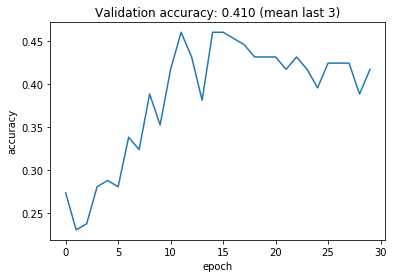

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)

plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:]) )) # last three values

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

In [7]:
# Decision tree accuracy to append into the file 
f_fileApp('data/results09.csv',8,"cnn", test_acc)

#### - Can you get good results? - If not, why?

With 256 neurons (with dropouts) and `epoch=30` we reasonably got good results: `0.821`. However, by increasing the number of epochs and small images in size but more in number, we could get even better results.